
## 🔹 Label Encoder

**What it does:**
Turns categories (text labels) into **numbers**.

**Example:**
Suppose you have a column:

```
Color
Red
Blue
Green
```

Label Encoding might convert it to:

```
Red   → 2
Blue  → 0
Green → 1
```

**Key points:**

* Each category gets **one integer**
* Simple and compact
* ⚠️ The numbers create an **artificial order** (Blue < Green < Red), even though no real order exists

**Best used when:**

* The categories **are ordinal** (e.g., Small < Medium < Large)
* Or with tree-based models (Decision Trees, Random Forests) that don’t care about numeric order much

---

## 🔹 One-Hot Encoder

**What it does:**
Turns categories into **binary columns (0/1)**.

**Example:**
Same data:

```
Color
Red
Blue
Green
```

One-Hot Encoding becomes:

```
Color_Blue  Color_Green  Color_Red
1           0            0
0           1            0
0           0            1
```

**Key points:**

* No false ordering
* Each category gets its **own column**
* More columns → higher dimensionality

**Best used when:**

* Categories are **nominal** (no order)
* Using linear models (Logistic Regression, Linear Regression, SVM, Neural Networks)

---

## ⚖️ Quick Comparison

| Feature        | Label Encoder | One-Hot Encoder  |
| -------------- | ------------- | ---------------- |
| Output         | Single column | Multiple columns |
| Order implied? | ❌ Yes         | ✅ No             |
| Memory usage   | Low           | Higher           |
| Common use     | Ordinal data  | Nominal data     |

---

### 🧠 Rule of thumb

* **Ordinal data?** → Label Encoder
* **Nominal data?** → One-Hot Encoder



# decision tree

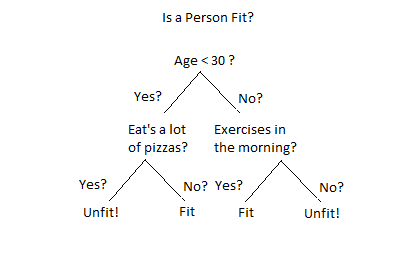

# Entropy

In [1]:
import math
from collections import Counter

def entropy(y):
    counts = Counter(y)
    total = len(y)

    ent = 0
    for count in counts.values():
        p = count / total
        ent -= p * math.log2(p)
    return ent


# Information Gain

In [2]:
def information_gain(X, y, feature_index):
    total_entropy = entropy(y)

    values = set(row[feature_index] for row in X)
    weighted_entropy = 0

    for value in values:
        sub_y = [
            y[i] for i in range(len(y))
            if X[i][feature_index] == value
        ]
        weighted_entropy += (len(sub_y) / len(y)) * entropy(sub_y)

    return total_entropy - weighted_entropy


# Tree

In [3]:
class Node:
    def __init__(self, feature=None, value=None, label=None):
        self.feature = feature    # feature index
        self.value = value        # feature value
        self.label = label        # class label (for leaf)
        self.children = {}


In [9]:
class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.root = None

    def fit(self, X, y):
        self.root = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        # If all labels same → leaf
        if len(set(y)) == 1:
            return Node(label=y[0])

        # Stop if max depth reached
        if self.max_depth is not None and depth >= self.max_depth:
            return Node(label=Counter(y).most_common(1)[0][0])

        # Find best feature
        best_feature = None
        best_gain = -1

        for i in range(len(X[0])):
            gain = information_gain(X, y, i)
            if gain > best_gain:
                best_gain = gain
                best_feature = i

        if best_gain == 0:
            return Node(label=Counter(y).most_common(1)[0][0])

        node = Node(feature=best_feature)

        feature_values = set(row[best_feature] for row in X)

        for value in feature_values:
            sub_X = []
            sub_y = []

            for i in range(len(X)):
                if X[i][best_feature] == value:
                    sub_X.append(X[i])
                    sub_y.append(y[i])

            node.children[value] = self._build_tree(
                sub_X, sub_y, depth + 1
            )

        return node

    def predict_one(self, x, node):
        if node.label is not None:
            return node.label

        value = x[node.feature]
        child = node.children.get(value)

        if child is None:
            return None  # unseen value

        return self.predict_one(x, child)

    def predict(self, X):
        return [self.predict_one(x, self.root) for x in X]

In [10]:
# Example dataset
X = [
    ['Sunny', 'Hot'],
    ['Sunny', 'Hot'],
    ['Overcast', 'Hot'],
    ['Rain', 'Mild'],
    ['Rain', 'Cool'],
    ['Rain', 'Cool'],
    ['Overcast', 'Cool'],
]

y = ['No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes']

tree = DecisionTree(max_depth=3)
tree.fit(X, y)

print(tree.predict([['Sunny', 'Cool'], ['Rain', 'Mild']]))


['No', 'Yes']


# Sklearn

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import tree


In [12]:
# Example dataset
X = [
    ['Sunny', 'Hot'],
    ['Sunny', 'Hot'],
    ['Overcast', 'Hot'],
    ['Rain', 'Mild'],
    ['Rain', 'Cool'],
    ['Rain', 'Cool'],
    ['Overcast', 'Cool'],
]

y = ['No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes']


In [13]:
encoder = LabelEncoder()

X_encoded = []
for col in zip(*X):          # column-wise
    X_encoded.append(encoder.fit_transform(col))

X_encoded = list(zip(*X_encoded))


In [14]:
y_encoded = encoder.fit_transform(y)
y_encoded

array([0, 0, 1, 1, 1, 0, 1])

In [15]:
clf = DecisionTreeClassifier(
    criterion="entropy",   # use entropy (ID3-style)
    max_depth=3,
    random_state=42
)

clf.fit(X_encoded, y_encoded)


DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)

In [16]:
test = [['Sunny', 'Cool'], ['Rain', 'Mild']]

test_encoded = []
for col in zip(*test):
    test_encoded.append(encoder.fit_transform(col))

test_encoded = list(zip(*test_encoded))

predictions = clf.predict(test_encoded)
print(predictions)


[0 1]


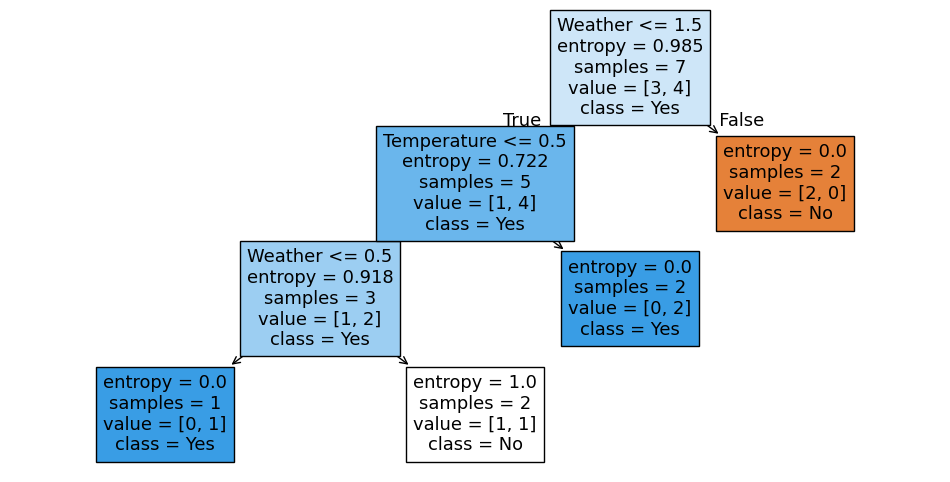

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
tree.plot_tree(
    clf,
    feature_names=['Weather', 'Temperature'],
    class_names=['No', 'Yes'],
    filled=True
)
plt.show()
